In [1]:
# import keras
# Source for HAM10000: https://www.kaggle.com/alexako/cs200-1-u-net-skin-lesion-segmentation

import cv2
import numpy as np
import glob
import os
from pathlib import Path
from PIL import Image
import random

In [2]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import adam_v2 #, SGD

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2t
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
root_folder = r"/content/drive/MyDrive/Spring 2022/Machine Learning for Physical Applications/Project/Manas Trials/Self-Supervised/"

In [ ]:
filelist_trainx = sorted(glob.glob(os.path.join(root_folder, "archive/ph2_resized", "trainx","*.bmp"))) #, key=numericalSort
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])
print(filelist_trainx[21])

filelist_trainy = sorted(glob.glob(os.path.join(root_folder, "archive/ph2_resized", "trainy","*.bmp"))) # , key=numericalSort
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

In [ ]:
# glob.glob(os.path.join(root_folder, "archive/ph2_resized", "trainx","*.bmp"))
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [ ]:
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [ ]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [ ]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [ ]:
def img_augmentation(x_test, y_test):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_test)):
        x,y = random_rotation(x_test[idx], y_test[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_test[idx], y_test[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [ ]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

In [ ]:
# For training Set
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.30, random_state = 101)

In [ ]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 315
Length of the Test Set       : 50
Length of the Validation Set : 135


In [ ]:
def encoder(img_input):
  x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
  x = BatchNormalization(name='bn1')(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
  x = BatchNormalization(name='bn2')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
  x = BatchNormalization(name='bn3')(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
  x = BatchNormalization(name='bn4')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
  x = BatchNormalization(name='bn5')(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
  x = BatchNormalization(name='bn6')(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
  x = BatchNormalization(name='bn7')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
  x = BatchNormalization(name='bn8')(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
  x = BatchNormalization(name='bn9')(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
  x = BatchNormalization(name='bn10')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
  x = BatchNormalization(name='bn11')(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
  x = BatchNormalization(name='bn12')(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
  x = BatchNormalization(name='bn13')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)

  x = Dense(1024, activation = 'relu', name='fc1')(x)
  x = Dense(1024, activation = 'relu', name='fc2')(x)

  return x

In [ ]:
def decoder(enc):
  # Decoding Layer 
  x = UpSampling2D()(enc)
  x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
  x = BatchNormalization(name='bn14')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
  x = BatchNormalization(name='bn15')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
  x = BatchNormalization(name='bn16')(x)
  x = Activation('relu')(x)

  x = UpSampling2D()(x)
  x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
  x = BatchNormalization(name='bn17')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
  x = BatchNormalization(name='bn18')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
  x = BatchNormalization(name='bn19')(x)
  x = Activation('relu')(x)

  x = UpSampling2D()(x)
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
  x = BatchNormalization(name='bn20')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
  x = BatchNormalization(name='bn21')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
  x = BatchNormalization(name='bn22')(x)
  x = Activation('relu')(x)

  x = UpSampling2D()(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
  x = BatchNormalization(name='bn23')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
  x = BatchNormalization(name='bn24')(x)
  x = Activation('relu')(x)

  x = UpSampling2D()(x)
  x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
  x = BatchNormalization(name='bn25')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
  x = BatchNormalization(name='bn26')(x)
  x = Activation('sigmoid')(x)
  return x


In [ ]:
def unet():

    # Encoding layer
#     img_input = Input(shape= (192, 256, 3))
    img_input = Input(shape= (None, None, 3))
    enc = encoder(img_input)
    dec = decoder(enc)
    pred = Reshape((192,256))(dec)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= adam_v2.Adam(learning_rate=0.001), loss= ["binary_crossentropy"]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    # , momentum=0.9, decay=0.0005, nesterov=False)
    print("Model compiled successfully") #model.summary()
    return model

In [ ]:
def train(epochs_num, savename):
    model = unet() #epochs_num, savename)
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18, validation_data= (x_val, y_val), verbose=1)
    model.save(savename)
    return model,hist

In [ ]:
base_epochs = 100
weight_path = os.path.join(root_folder,'unet_'+str(base_epochs)+'_epoch.h5')
model, hist = train(base_epochs, weight_path)

Model compiled successfully
Epoch 1/100
18/18 [==============================] - 16s 717ms/step - loss: 0.5339 - iou: 0.7723 - dice_coef: 0.5363 - precision: 0.6876 - recall: 0.7371 - accuracy: 0.7955 - val_loss: 10.2617 - val_iou: 0.5135 - val_dice_coef: 0.4782 - val_precision: 0.3157 - val_recall: 0.9985 - val_accuracy: 0.3232
Epoch 2/100
18/18 [==============================] - 12s 671ms/step - loss: 0.4449 - iou: 0.8126 - dice_coef: 0.5847 - precision: 0.8040 - recall: 0.8376 - accuracy: 0.8725 - val_loss: 10.4190 - val_iou: 0.5085 - val_dice_coef: 0.4748 - val_precision: 0.3127 - val_recall: 1.0000 - val_accuracy: 0.3128
Epoch 3/100
18/18 [==============================] - 12s 678ms/step - loss: 0.4172 - iou: 0.8278 - dice_coef: 0.6042 - precision: 0.8230 - recall: 0.8834 - accuracy: 0.8963 - val_loss: 10.3684 - val_iou: 0.5097 - val_dice_coef: 0.4759 - val_precision: 0.3136 - val_recall: 0.9996 - val_accuracy: 0.3161
Epoch 4/100
18/18 [==============================] - 12s 690ms/

In [ ]:
img = tf.convert_to_tensor(np.expand_dims(x_train[21],0), dtype='float')

In [ ]:
encoded = encoder(img)


In [ ]:
encoded.shape

TensorShape([1, 6, 8, 1024])

In [ ]:
model0 = unet()

Model compiled successfully


In [ ]:
model0.load_weights(weight_path)

In [ ]:
model0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 64)    1792      
                                                                 
 bn1 (BatchNormalization)    (None, None, None, 64)    256       
                                                                 
 activation_39 (Activation)  (None, None, None, 64)    0         
                                                                 
 conv2 (Conv2D)              (None, None, None, 64)    36928     
                                                                 
 bn2 (BatchNormalization)    (None, None, None, 64)    256       
                                                                 
 activation_40 (Activation)  (None, None, None, 64)    0   

In [ ]:
enc_in_tensor = model.input
enc_out_tensor = model.get_layer('bn10').output # fc2

In [ ]:
encoder_model = Model(inputs = enc_in_tensor, outputs = enc_out_tensor)

In [ ]:
encoder_model.load_weights(weight_path, by_name=True)

In [ ]:
encoder_model(img).shape

TensorShape([1, 24, 32, 512])

In [ ]:
# 1: https://stackoverflow.com/questions/58465937/how-to-use-the-first-layers-of-a-pretrained-model-to-extract-features-inside-a-k
# 2: https://stackoverflow.com/questions/58465937/how-to-use-the-first-layers-of-a-pretrained-model-to-extract-features-inside-a-k

In [ ]:
def rms_loss20(y_true, y_pred):
    y_true_f = 20*K.flatten(y_true)
    y_pred_f = 20*K.flatten(y_pred)
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
from keras.layers.pooling import GlobalAveragePooling2D
def classify(img_input):
  enc = encoder_model(img_input)
  x = GlobalAveragePooling2D(name='gap0')(enc)
  x = Dense(64, activation='relu', name='clf_1')(x)
  clf = Dense(1, activation='sigmoid', name='clf_final')(x)
  model = Model(inputs=img_input, outputs=clf)
  model.compile(loss=['mse'], optimizer=adam_v2.Adam(learning_rate=0.001), metrics=[rms_loss20])
  print("Classifier compiled successfully")
  return model

In [ ]:
clf_model = classify(Input(shape= (None, None, 3)))
out = clf_model(img)
out.shape

Classifier compiled successfully


TensorShape([1, 1])

In [ ]:
dataset_folder = r"/content/drive/MyDrive/Spring 2022/Machine Learning for Physical Applications/Project/dataset_anemia/Final_Augmented_Data/"

In [ ]:
class DataLoader():
  def __init__(self) -> None:
      self.path = dataset_folder # path to augmented data
      self.folders = ['Flip','Rotate','Scale','Translation']
      self.y_italy = pd.read_excel(r"/content/drive/MyDrive/Spring 2022/Machine Learning for Physical Applications/Project/TRIAL/Italy_new.xlsx")
      #r'/content/drive/MyDrive/Course_files/228/dataset_anemia/India/India.xlsx')#np.load("/content/drive/MyDrive/Course_files/228/dataset_anemia/y_india.npy")
      self.y_india = pd.read_excel(r"/content/drive/MyDrive/Spring 2022/Machine Learning for Physical Applications/Project/dataset_anemia/India/India.xlsx")
      #r'/content/drive/MyDrive/Course_files/228/dataset_anemia/Italy/Italy_copy.xlsx')#np.load("/content/drive/MyDrive/Course_files/228/dataset_anemia/y_base_italy.npy")
      # self.split = 1#0.5 #italy/india split
      self.skip = 95 #Skip value in Italy (No value)
      self.split = [0.8,0.1,0.1] #train,val,test
  def sample(self,num,j):
    # num_italy = int(num*self.split)
    # num_india = num - num_italy
    X = np.zeros((num,640,480,3))
    Y = np.zeros(num)
    age = np.zeros(num)
    gen = np.zeros(num)
    seen =[]
    for i in range(num):
      f = np.random.randint(0,len(folders))
      path = self.path+self.folders[f]
      l = os.listdir(path)
      if j ==0:
        im_p = os.listdir(path)[0:int(len(l)*self.split[j])]
      else:
        im_p = os.listdir(path)[int(len(l)*self.split[j-1]):int(len(l)*self.split[j])]
      image = random.choice(os.listdir(path))
      name_list = image.replace(".jpg","").split('_')
      country = name_list[0]
      id = int(name_list[1])
      if country =='italy':
        try:
          s = d.y_italy["Number"]==id
          s[s==True].index[-1]
          Y[i] = float(self.y_italy['Hgb'][s])/20
          # age[i] = 
        except:
          continue
      elif country =='india':
        s = d.y_india["Number"]==float(id)
        s[s==True].index[-1]
        Y[i] = float(self.y_india['Hgb'][s])/20
      X[i,:,:,:] = cv2.imread(path+'/' + image)/255
    X = np.array(X)
    Y = np.array(Y)
    return X,Y
  def sample_v(self,num,j):
    # num_italy = int(num*self.split)
    # num_india = num - num_italy
    X = np.zeros((num,640,480,3))
    Y = np.zeros(num)
    seen =[]
    for i in range(num):
      # f = np.random.randint(0,?len(folders))
      path = self.path+"Scale"
      l = os.listdir(path)
      im_p = os.listdir(path)[0:int(len(l)*self.split[j])]
      image = random.choice(os.listdir(path))
      name_list = image.replace(".jpg","").split('_')
      country = name_list[0]
      id = int(name_list[1])
      if country =='italy':
        try:
          s = d.y_italy["Number"]==id
          s[s==True].index[-1]
          Y[i] = float(self.y_italy['Hgb'][s])/20
        except:
          continue
      elif country =='india':
        s = d.y_india["Number"]==float(id)
        s[s==True].index[-1]
        Y[i] = float(self.y_india['Hgb'][s])/20
      X[i,:,:,:] = cv2.imread(path+'/' + image)/255
    X = np.array(X)
    Y = np.array(Y)
    return X,Y

In [ ]:
del x_train_full
del y_train_full
del x_train
del y_train

NameError: ignored

In [ ]:
d = DataLoader()
X_clf,y_clf = d.sample_v(300,1)
# X =np.zeros((200,3,640,480))
# X[:,0,:,:] = x[:,:,:,0]
# X[:,1,:,:] = x[:,:,:,1]
# X[:,2,:,:] = x[:,:,:,2]


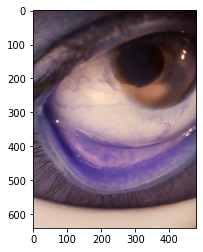

In [ ]:
plt.imshow(X_clf[21], cmap='brg')

In [ ]:
# filelist_trainx = sorted(glob.glob(os.path.join(root_folder, "archive/ph2_resized", "trainx","*.bmp"))) #, key=numericalSort
# X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])
# print(filelist_trainx[21])

# filelist_trainy = sorted(glob.glob(os.path.join(root_folder, "archive/ph2_resized", "trainy","*.bmp"))) # , key=numericalSort
# Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

In [ ]:
X_clf_use, X_clf_test, y_clf_use, y_clf_test = train_test_split(X_clf, y_clf, test_size = 0.1, random_state = 101)
X_clf_train, X_clf_val, y_clf_train, y_clf_val = train_test_split(X_clf_use, y_clf_use, test_size = 0.1, random_state = 101)

In [ ]:
X_clf_train.shape, X_clf_val.shape, X_clf_test.shape

((243, 640, 480, 3), (27, 640, 480, 3), (30, 640, 480, 3))

In [ ]:
y_clf_test

array([0.54 , 0.765, 0.61 , 0.76 , 0.635, 0.634, 0.68 , 0.81 , 0.445,
       0.77 , 0.74 , 0.   , 0.725, 0.805, 0.685, 0.53 , 0.565, 0.55 ,
       0.695, 0.735, 0.555, 0.765, 0.7  , 0.75 , 0.515, 0.705, 0.56 ,
       0.79 , 0.775, 0.745])

In [ ]:
def train_clf(epochs_num, savename):
    model =  classify(Input(shape= (None, None, 3))) #epochs_num, savename)
    hist = model.fit(X_clf_use, y_clf_use, epochs= epochs_num, batch_size= 6, validation_data= (X_clf_val, y_clf_val), verbose=1)
    model.save(savename)
    return model,hist

In [ ]:
del X_clf
del y_clf

In [ ]:
epochs = 10
clf_weight_path = os.path.join(root_folder,'clf_'+str(epochs)+'_epoch.h5')
clf_model, hist = train_clf(epochs, clf_weight_path)

Classifier compiled successfully
Epoch 1/10
45/45 [==============================] - 34s 681ms/step - loss: 0.0217 - rms_loss20: 0.1379 - val_loss: 0.1536 - val_rms_loss20: 0.3841
Epoch 2/10
45/45 [==============================] - 30s 675ms/step - loss: 0.0093 - rms_loss20: 0.0921 - val_loss: 0.1536 - val_rms_loss20: 0.3841
Epoch 3/10
45/45 [==============================] - 30s 678ms/step - loss: 0.0079 - rms_loss20: 0.0857 - val_loss: 0.0241 - val_rms_loss20: 0.1482
Epoch 4/10
45/45 [==============================] - 31s 687ms/step - loss: 0.0078 - rms_loss20: 0.0830 - val_loss: 0.0153 - val_rms_loss20: 0.1217
Epoch 5/10
45/45 [==============================] - 31s 694ms/step - loss: 0.0081 - rms_loss20: 0.0868 - val_loss: 0.0144 - val_rms_loss20: 0.1197
Epoch 6/10
45/45 [==============================] - 31s 699ms/step - loss: 0.0085 - rms_loss20: 0.0884 - val_loss: 0.0139 - val_rms_loss20: 0.1144
Epoch 7/10
45/45 [==============================] - 32s 705ms/step - loss: 0.0076 - r

In [ ]:
 X_clf_train.shape, y_clf_train.shape

((243, 640, 480, 3), (243,))

In [ ]:
y_clf_test[2:5]

array([0.41 , 0.635, 0.65 ])

In [ ]:
rms_loss20(y_clf_test[12:15],clf_model(X_clf_test[12:15]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.2576797>

In [ ]:
clf_model(X_clf_test[12:15]), y_clf_test[12:15]

(<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.8713867 ],
        [0.87366927],
        [0.8712872 ]], dtype=float32)>, array([0.685, 0.48 , 0.77 ]))